# Inicialização

In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import snscrape.modules.twitter as sntwitter
from tqdm import tqdm

# Oculta warnings do notebook
# import warnings
# warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
dataset_path = '../data/raw/'
dataset_name = 'consulta_cand_2022_SP.csv'
cand_sp_df = pd.read_csv(f"{dataset_path}{dataset_name}", sep=';')
print(cand_sp_df.shape)
cand_sp_df.info()

(3659, 71)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DT_GERACAO                     3659 non-null   object 
 1   HH_GERACAO                     3659 non-null   object 
 2   ANO_ELEICAO                    3659 non-null   int64  
 3   CD_TIPO_ELEICAO                3659 non-null   int64  
 4   NM_TIPO_ELEICAO                3659 non-null   object 
 5   NR_TURNO                       3659 non-null   int64  
 6   CD_ELEICAO                     3659 non-null   int64  
 7   DS_ELEICAO                     3659 non-null   object 
 8   DT_ELEICAO                     3659 non-null   object 
 9   TP_ABRANGENCIA                 3659 non-null   object 
 10  SG_UF                          3659 non-null   object 
 11  SG_UE                          3659 non-null   object 
 12  NM_UE                          3659 n

In [4]:
# Carregando dataset com os dados de redes sociais dos candidatos de SP nas eleições de 2022
rs_df = pd.read_csv(f"{dataset_path}rede_social_candidato_2022_SP.csv", sep=';')
print(rs_df.shape)
rs_df.info()

(6735, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6735 entries, 0 to 6734
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DT_GERACAO       6735 non-null   object
 1   HH_GERACAO       6735 non-null   object
 2   AA_ELEICAO       6735 non-null   int64 
 3   SG_UF            6735 non-null   object
 4   CD_TIPO_ELEICAO  6735 non-null   int64 
 5   NM_TIPO_ELEICAO  6735 non-null   object
 6   CD_ELEICAO       6735 non-null   int64 
 7   DS_ELEICAO       6735 non-null   object
 8   SQ_CANDIDATO     6735 non-null   int64 
 9   NR_ORDEM         6735 non-null   int64 
 10  DS_URL           6735 non-null   object
dtypes: int64(5), object(6)
memory usage: 578.9+ KB


## Juntando os datasets

In [5]:
# Filtrando somente candidatos com conta no Twitter
rs_twitter_df = rs_df[rs_df.DS_URL.str.contains('twitter', case=False)]
print(rs_twitter_df.shape)

(624, 11)


In [6]:
# Juntando as duas bases
df = pd.merge(cand_sp_df, rs_twitter_df[['SQ_CANDIDATO', 'DS_URL']], on="SQ_CANDIDATO", how="left")
df.shape

(3682, 72)

In [7]:
# Filtrando somente candidatos a deputado estadual
candidates_df = df.loc[
    (df['DS_CARGO'] == 'DEPUTADO ESTADUAL')
]

print(candidates_df.shape)

(2068, 72)


# Checagem dos dados

## Dados duplicados

In [8]:
# Vamos checar os candidatos duplicados
duplicated_candidates_id = (candidates_df.SQ_CANDIDATO.value_counts() > 1).loc[lambda x: x == True].index
candidates_df[candidates_df['SQ_CANDIDATO'].isin(duplicated_candidates_id)][['SQ_CANDIDATO', 'DS_URL']]

,SQ_CANDIDATO,DS_URL
179,250001643640,https://twitter.com/DrMarcioAurelio
180,250001643640,https://twitter.com/DrMarcioAurelio
181,250001643640,https://twitter.com/raiztrabalhista
578,250001619366,https://twitter.com/MarinadaMantiq1?t=8vFxK3Hx...
579,250001619366,https://twitter.com/Mantiqueira18?t=hLpMVYYVZ0...
885,250001611799,https://twitter.com/depeniotatto
886,250001611799,https://www.twitter.com/eniotatto13114
2344,250001620657,https://www.twitter.com/FabioAdonis
2345,250001620657,https://twitter.com/fabiojabaDGtal?t=45hkTz2X4...
2688,250001611457,https://twitter.com/alefrota77


In [9]:
# Vamos checar estas contas no Twitter
drop_list = []

# A conta DrMarcioAurelio está repetida, portanto vamos remover uma das linhas
drop_list.append(180)

# A conta raiztrabalhista é de um coletivo político e não do candidato
drop_list.append(181)

# A conta Mantiqueira18 é de um coletivo político e não do candidato
drop_list.append(579)

# A conta eniotatto13114 não existe mais
drop_list.append(886)

# A conta FabioAdonis é pessoal e não posta desde 2017
drop_list.append(2344)

# A conta alefrota77 não existe mais
drop_list.append(2688)

# A conta GeraldóNobrega não existe mais
drop_list.append(2784)

# A conta rodrigo_pt13 não tem nenhum tweet
drop_list.append(3442)

# A conta valverdemogi possui apenas um tweet de 2021
drop_list.append(3443)

In [10]:
# Removendo as contas acima
candidates_df = candidates_df.drop(drop_list)

# Exploração dos dados

In [11]:
# Vamos criar diferentes segmentações, para facilitar a comparação de diversidade
elected_values = ['ELEITO POR QP', 'ELEITO POR MÉDIA', 'ELEITO']

# Deputados estaduais eleitos
elected_df = candidates_df.loc[
    (candidates_df['DS_SIT_TOT_TURNO'].isin(elected_values))
]

# Deputados estaduais eleitos com perfil no Twitter
twitter_df = elected_df.loc[
    (elected_df['DS_URL'].notna())
]

print(candidates_df.shape)
print(elected_df.shape)
print(twitter_df.shape)

(2059, 72)
(94, 72)
(49, 72)


### Analisando a diversidade

In [12]:
print('Candidatos a deputado estadual')
print(candidates_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size())
print()
print('Candidatos a deputado estadual eleitos')
print(elected_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size())
print()
print('Candidatos a deputado estadual eleitos com conta no Twitter')
print(twitter_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size())
print()

Candidatos a deputado estadual
DS_GENERO       DS_COR_RACA   
FEMININO        AMARELA             8
                BRANCA            419
                INDÍGENA            2
                PARDA             115
                PRETA             132
MASCULINO       AMARELA            11
                BRANCA            906
                INDÍGENA            4
                NÃO INFORMADO       1
                PARDA             318
                PRETA             142
NÃO DIVULGÁVEL  NÃO DIVULGÁVEL      1
dtype: int64

Candidatos a deputado estadual eleitos
DS_GENERO  DS_COR_RACA
FEMININO   BRANCA         19
           PARDA           1
           PRETA           5
MASCULINO  BRANCA         57
           PARDA           8
           PRETA           4
dtype: int64

Candidatos a deputado estadual eleitos com conta no Twitter
DS_GENERO  DS_COR_RACA
FEMININO   BRANCA         11
           PARDA           1
           PRETA           4
MASCULINO  BRANCA         31
           PARDA   

Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter


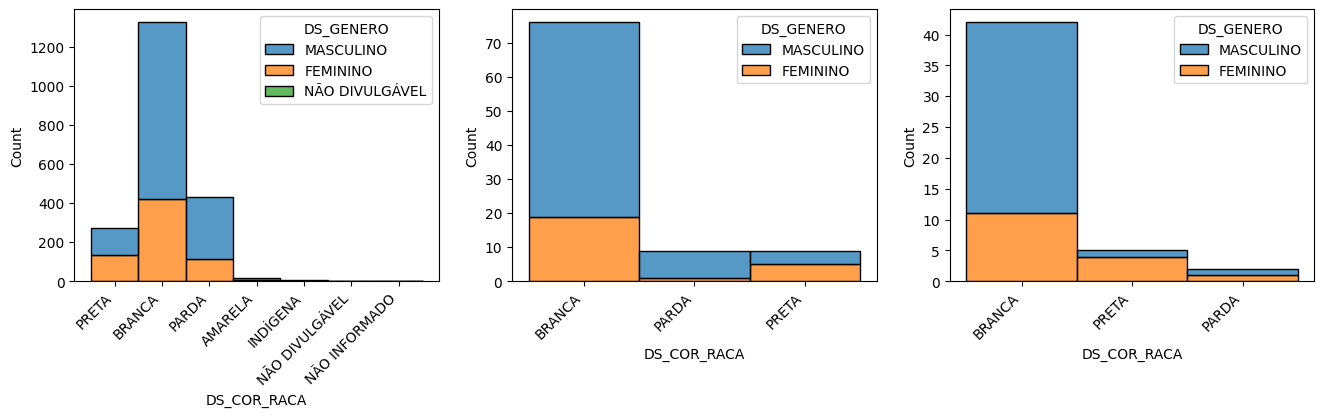

In [13]:
# Visualizando a distribuição de gênero em raça, entre o candidatos, os eleitos e os eleitos com Twitter
fig, ax = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
fig.autofmt_xdate(rotation=45)

sns.histplot(
    data=candidates_df,
    hue='DS_GENERO',
    x='DS_COR_RACA',
    multiple='stack',
    ax=ax[0][0],
)

sns.histplot(
    data=elected_df,
    hue='DS_GENERO',
    x='DS_COR_RACA',
    multiple='stack',
    ax=ax[0][1],
)

sns.histplot(
    data=twitter_df,
    hue='DS_GENERO',
    x='DS_COR_RACA',
    multiple='stack',
    ax=ax[0][2],
)

print('Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter')
plt.show()

Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter


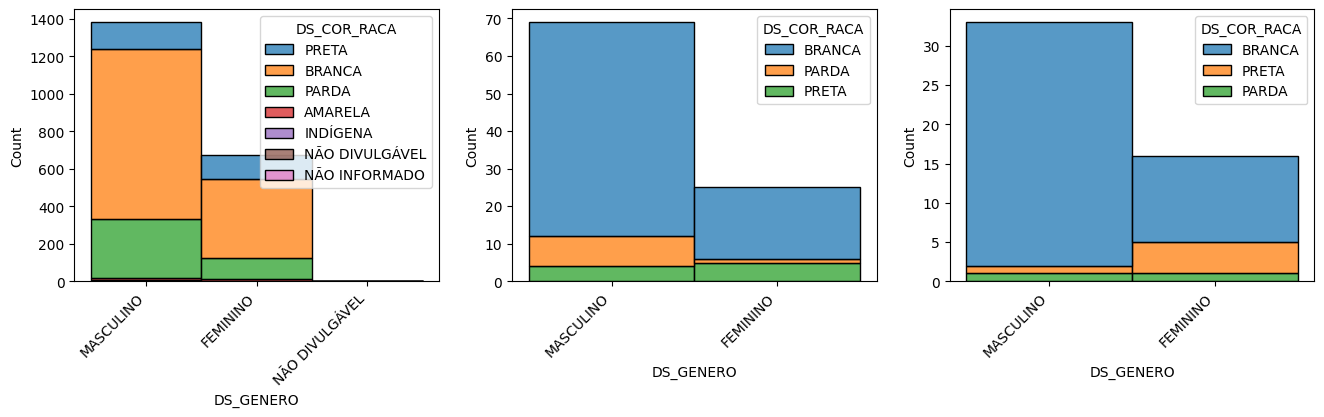

In [14]:
# Visualizando a distribuição de gênero e raça, entre o candidatos, os eleitos e os eleitos com Twitter
fig, ax = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
fig.autofmt_xdate(rotation=45)

sns.histplot(
    data=candidates_df,
    hue='DS_COR_RACA',
    x='DS_GENERO',
    multiple='stack',
    ax=ax[0][0],
)

sns.histplot(
    data=elected_df,
    hue='DS_COR_RACA',
    x='DS_GENERO',
    multiple='stack',
    ax=ax[0][1],
)

sns.histplot(
    data=twitter_df,
    hue='DS_COR_RACA',
    x='DS_GENERO',
    multiple='stack',
    ax=ax[0][2],
)

print('Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter')
plt.show()

# Extração de dados do Twitter

## Dados das contas

In [15]:
# Vamos listar as contas no twitter dos deputados estaduais eleitos
twitter_df.DS_URL

22                          https://www.twitter/dreltonjr
232              https://twitter.com/EdianeMariaMTST?s=09
276     https://twitter.com/fabibbolsonaro?s=21&t=yq90...
318                      https://twitter.com/delegadoolim
367     https://www.twitter.com/https://twitter.com/le...
391     https://twitter.com/bethsahao?ref_src=twsrc%5E...
427                          https://twitter.com/sppretas
458                    https://www.twitter.com/tomeabduch
459                     https://twitter.com/prcarloscezar
490                        https://twitter.com/majormecca
514                      https://twitter.com/valbolsonaro
560                      https://twitter.com/zimbaldirafa
599                    https://twitter.com/CarlosGiannazi
660              https://twitter.com/tenente_coimbra?s=11
690                   https://twitter.com/rafaelsaraivasp
741                    https://twitter.com/BrunoZambelli3
742                      https://twitter.com/LFTeixeira13
810           

In [18]:
# Como precisamos somente do username, precisamos aplicar uma função
def get_twitter_username(link):
    link = link.rstrip('/')
    username = link.split('/')[-1]
    username = username.split('?')[0]
    return username.lower()

twitter_df['TW_USER'] = twitter_df.DS_URL.apply(get_twitter_username)
twitter_df['TW_USER'].describe()

/tmp/ipykernel_3725/2390309642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_USER'] = twitter_df.DS_URL.apply(get_twitter_username)


count            49
unique           49
top       dreltonjr
freq              1
Name: TW_USER, dtype: object

In [19]:
%%time
# Vamos raspar os dados numéricos de cada uma das contas do Twitter
usernames = list(twitter_df['TW_USER'])

user_data = {}
for i, username in enumerate(usernames):
    try:
        last_tweet = next(sntwitter.TwitterProfileScraper(username).get_items())
        user_data[username] = {
            'followersCount': last_tweet.user.followersCount,
            'friendsCount': last_tweet.user.friendsCount,
            'statusesCount': last_tweet.user.statusesCount,
            'favouritesCount': last_tweet.user.favouritesCount,
            'listedCount': last_tweet.user.listedCount,
            'mediaCount': last_tweet.user.mediaCount,
        }
        print(f'{i+1}/{len(usernames)} {username}: {user_data[username]}')
    except Exception as e:
        print(f'{i+1}/{len(usernames)} {username}: Erro {e}')
        user_data[username] = {
            'followersCount': 0,
            'friendsCount': 0,
            'statusesCount': 0,
            'favouritesCount': 0,
            'listedCount': 0,
            'mediaCount': 0,
        }

1/49 dreltonjr: {'followersCount': 873, 'friendsCount': 462, 'statusesCount': 743, 'favouritesCount': 301, 'listedCount': 1, 'mediaCount': 480}
2/49 edianemariamtst: {'followersCount': 14515, 'friendsCount': 249, 'statusesCount': 3602, 'favouritesCount': 3146, 'listedCount': 41, 'mediaCount': 581}
3/49 fabibbolsonaro: {'followersCount': 15488, 'friendsCount': 7083, 'statusesCount': 99, 'favouritesCount': 500, 'listedCount': 3, 'mediaCount': 40}
4/49 delegadoolim: {'followersCount': 2968, 'friendsCount': 0, 'statusesCount': 1924, 'favouritesCount': 233, 'listedCount': 37, 'mediaCount': 465}
5/49 leosiqueirabr: {'followersCount': 54542, 'friendsCount': 1088, 'statusesCount': 8784, 'favouritesCount': 4871, 'listedCount': 349, 'mediaCount': 955}
6/49 bethsahao: {'followersCount': 2745, 'friendsCount': 1576, 'statusesCount': 9676, 'favouritesCount': 3870, 'listedCount': 70, 'mediaCount': 545}
7/49 sppretas: {'followersCount': 1792, 'friendsCount': 18, 'statusesCount': 283, 'favouritesCount'

Empty response


8/49 tomeabduch: Erro Could not resolve username 'tomeabduch' to ID
9/49 prcarloscezar: {'followersCount': 5522, 'friendsCount': 585, 'statusesCount': 18248, 'favouritesCount': 220, 'listedCount': 75, 'mediaCount': 1739}
10/49 majormecca: {'followersCount': 28389, 'friendsCount': 967, 'statusesCount': 12135, 'favouritesCount': 24867, 'listedCount': 60, 'mediaCount': 3855}
11/49 valbolsonaro: {'followersCount': 53841, 'friendsCount': 327, 'statusesCount': 4165, 'favouritesCount': 26495, 'listedCount': 122, 'mediaCount': 1250}
12/49 zimbaldirafa: {'followersCount': 1098, 'friendsCount': 351, 'statusesCount': 2508, 'favouritesCount': 129, 'listedCount': 38, 'mediaCount': 366}
13/49 carlosgiannazi: {'followersCount': 21233, 'friendsCount': 827, 'statusesCount': 14227, 'favouritesCount': 14502, 'listedCount': 242, 'mediaCount': 7533}
14/49 tenente_coimbra: {'followersCount': 80547, 'friendsCount': 2998, 'statusesCount': 4415, 'favouritesCount': 4452, 'listedCount': 71, 'mediaCount': 612}
15

Empty response


17/49 lfteixeira13: Erro Could not resolve username 'lfteixeira13' to ID
18/49 emidiodesouza_: {'followersCount': 10348, 'friendsCount': 1095, 'statusesCount': 20131, 'favouritesCount': 5140, 'listedCount': 168, 'mediaCount': 2938}
19/49 esuplicy: {'followersCount': 723891, 'friendsCount': 3703, 'statusesCount': 14881, 'favouritesCount': 6639, 'listedCount': 2205, 'mediaCount': 5518}
20/49 depeniotatto: {'followersCount': 521, 'friendsCount': 70, 'statusesCount': 1218, 'favouritesCount': 6, 'listedCount': 18, 'mediaCount': 145}
21/49 anacarolserra23: {'followersCount': 189, 'friendsCount': 194, 'statusesCount': 38, 'favouritesCount': 1211, 'listedCount': 4, 'mediaCount': 17}
22/49 xerifedoconsum: {'followersCount': 1412, 'friendsCount': 4, 'statusesCount': 667, 'favouritesCount': 0, 'listedCount': 11, 'mediaCount': 175}
23/49 auricchiothiago: {'followersCount': 1003, 'friendsCount': 23, 'statusesCount': 887, 'favouritesCount': 27, 'listedCount': 27, 'mediaCount': 69}
24/49 itamar_borge

In [20]:
# Agora vamos adicionar os dados dos usuários no mesmo dataframe

# Quantidade de seguidores da conta
twitter_df['TW_followersCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['followersCount'])

# Quantidade de usuarios que a conta segue
twitter_df['TW_friendsCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['friendsCount'])

# Quantidade de tweets postados pela conta
twitter_df['TW_statusesCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['statusesCount'])

# Quantidade de tweets curtidos pela conta
twitter_df['TW_favouritesCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['favouritesCount'])

twitter_df['TW_listedCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['listedCount'])
twitter_df['TW_mediaCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['mediaCount'])

twitter_df.head()

/tmp/ipykernel_3725/2004623770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_followersCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['followersCount'])
/tmp/ipykernel_3725/2004623770.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_friendsCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['friendsCount'])
/tmp/ipykernel_3725/2004623770.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,...,CD_SITUACAO_CANDIDATO_URNA,DS_SITUACAO_CANDIDATO_URNA,ST_CANDIDATO_INSERIDO_URNA,NM_TIPO_DESTINACAO_VOTOS,CD_SITUACAO_CANDIDATO_TOT,DS_SITUACAO_CANDIDATO_TOT,ST_PREST_CONTAS,DS_URL,TW_USER,TW_followersCount,TW_friendsCount,TW_statusesCount,TW_favouritesCount,TW_listedCount,TW_mediaCount
22,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://www.twitter/dreltonjr,dreltonjr,873,462,743,301,1,480
232,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/EdianeMariaMTST?s=09,edianemariamtst,14515,249,3602,3146,41,581
276,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/fabibbolsonaro?s=21&t=yq90...,fabibbolsonaro,15488,7083,99,500,3,40
318,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/delegadoolim,delegadoolim,2968,0,1924,233,37,465
367,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://www.twitter.com/https://twitter.com/le...,leosiqueirabr,54542,1088,8784,4871,349,955


## Contagem de tweets

In [21]:
%%time
# Vamos contar quantos posts e respostas cada candidato teve no período analisado (setembro e outubro de 2022)
# Esta etapa pode demorar bastante
since = '2022-09-01'
until = '2022-11-01'

user_tweets = {}
for i, username in enumerate(usernames):
    try:
        query = f'from:{username} since:{since} until:{until}'
        user_scrapping_results = sntwitter.TwitterSearchScraper(query).get_items()
        tweets = []
        for tweet in user_scrapping_results:
            tweets.append(tweet)

        user_tweets[username] = {
            'posts': tweets,
            'count': len(tweets),
        }
        print(f'{i+1}/{len(usernames)} {username}: {len(tweets)} tweets')
    except Exception as e:
        print(f'{i+1}/{len(usernames)} {username}: Erro {e}')
        user_tweets[username] = {
            'posts': [],
            'count': 0,
        }

1/49 dreltonjr: 6 tweets
2/49 edianemariamtst: 1825 tweets
3/49 fabibbolsonaro: 4 tweets
4/49 delegadoolim: 0 tweets
5/49 leosiqueirabr: 553 tweets
6/49 bethsahao: 84 tweets
7/49 sppretas: 91 tweets
8/49 tomeabduch: 0 tweets
9/49 prcarloscezar: 108 tweets
10/49 majormecca: 605 tweets
11/49 valbolsonaro: 553 tweets
12/49 zimbaldirafa: 17 tweets
13/49 carlosgiannazi: 544 tweets
14/49 tenente_coimbra: 86 tweets
15/49 rafaelsaraivasp: 43 tweets
16/49 brunozambelli3: 1 tweets
17/49 lfteixeira13: 0 tweets
18/49 emidiodesouza_: 383 tweets
19/49 esuplicy: 300 tweets
20/49 depeniotatto: 159 tweets
21/49 anacarolserra23: 0 tweets
22/49 xerifedoconsum: 71 tweets
23/49 auricchiothiago: 10 tweets
24/49 itamar_borges: 139 tweets
25/49 simaopedro_sp: 865 tweets
26/49 danilobalas: 502 tweets
27/49 vcamarinha: 6 tweets
28/49 marcosdamasiosp: 5 tweets
29/49 lcmarcolino: 17 tweets
30/49 danialonsoda: 3 tweets
31/49 bfeministapsol: 845 tweets
32/49 gersonpessoa: 0 tweets
33/49 deleg_graciela: 0 tweets
34/

In [22]:
twitter_df['TW_electionTweets'] = twitter_df.TW_USER.apply(lambda x: user_tweets[x]['count'])
twitter_df['TW_electionTweets'].describe()

/tmp/ipykernel_3725/3948402191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_electionTweets'] = twitter_df.TW_USER.apply(lambda x: user_tweets[x]['count'])


count      49.00
mean      257.98
std       469.58
min         0.00
25%         5.00
50%        84.00
75%       300.00
max     2,508.00
Name: TW_electionTweets, dtype: float64

In [23]:
twitter_df.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_CARGO', 'DS_CARGO',
       'SQ_CANDIDATO', 'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'NR_CPF_CANDIDATO', 'NM_EMAIL',
       'CD_SITUACAO_CANDIDATURA', 'DS_SITUACAO_CANDIDATURA',
       'CD_DETALHE_SITUACAO_CAND', 'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO',
       'NR_PARTIDO', 'SG_PARTIDO', 'NM_PARTIDO', 'NR_FEDERACAO',
       'NM_FEDERACAO', 'SG_FEDERACAO', 'DS_COMPOSICAO_FEDERACAO',
       'SQ_COLIGACAO', 'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO',
       'CD_NACIONALIDADE', 'DS_NACIONALIDADE', 'SG_UF_NASCIMENTO',
       'CD_MUNICIPIO_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO', 'DT_NASCIMENTO',
       'NR_IDADE_DATA_POSSE', 'NR_TITULO_ELEITORAL_CANDIDATO', 'CD_GENERO',
       'DS_GENERO', 'CD_GRAU_INSTRUCAO', 'DS_GRAU_INSTRUCAO',
       'CD_ESTAD

In [24]:
twitter_df[twitter_df["TW_electionTweets"] > twitter_df.TW_electionTweets.median()].sort_values(
    by='TW_electionTweets', ascending=False
)[[
    'TW_USER', 'DS_GENERO', 'DS_COR_RACA', 'SG_PARTIDO', 'TW_followersCount', 'TW_statusesCount', 'TW_electionTweets'
]]

,TW_USER,DS_GENERO,DS_COR_RACA,SG_PARTIDO,TW_followersCount,TW_statusesCount,TW_electionTweets
2416,andreawerner_,FEMININO,BRANCA,PSB,63773,36889,2508
232,edianemariamtst,FEMININO,PRETA,PSOL,14515,3602,1825
1286,simaopedro_sp,MASCULINO,BRANCA,PT,13634,21115,865
1833,bfeministapsol,FEMININO,PRETA,PSOL,7983,4233,845
3310,carteiroreaca,MASCULINO,BRANCA,PL,528870,16311,769
490,majormecca,MASCULINO,BRANCA,PL,28389,12135,605
514,valbolsonaro,FEMININO,BRANCA,PL,53841,4165,553
367,leosiqueirabr,MASCULINO,BRANCA,NOVO,54542,8784,553
599,carlosgiannazi,MASCULINO,BRANCA,PSOL,21233,14227,544
1353,danilobalas,MASCULINO,BRANCA,PL,19958,3135,502


## Exploração dos dados do Twitter

<Axes: xlabel='TW_electionTweets', ylabel='Count'>

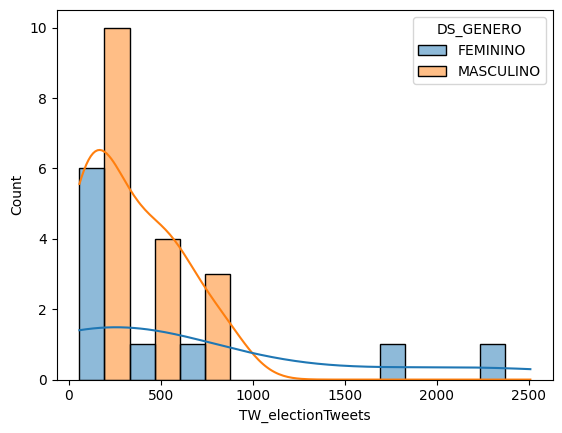

In [25]:
sns.histplot(
    data=twitter_df.loc[twitter_df['TW_electionTweets'] > 50],
    x='TW_electionTweets',
    hue='DS_GENERO',
    multiple='dodge',
    kde=True,
)

<Axes: xlabel='TW_followersCount', ylabel='Count'>

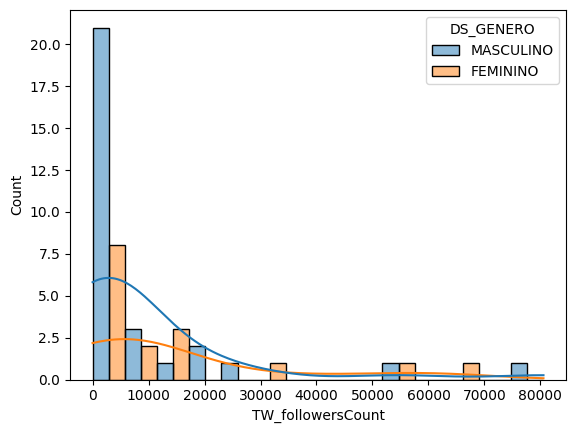

In [26]:
sns.histplot(
    data=twitter_df.loc[twitter_df['TW_followersCount'] < 100000],
    hue='DS_GENERO',
    x='TW_followersCount',
    multiple='dodge',
    kde=True,
)

<Axes: xlabel='TW_followersCount', ylabel='Count'>

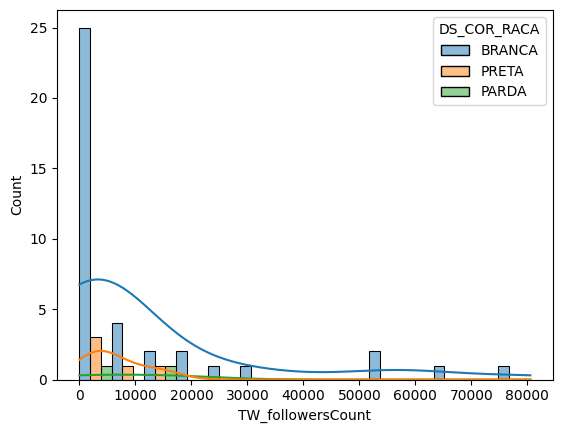

In [27]:
sns.histplot(
    data=twitter_df.loc[twitter_df['TW_followersCount'] < 100000],
    hue='DS_COR_RACA',
    x='TW_followersCount',
    multiple='dodge',
    kde=True,   
)

# Exportação de dados

In [28]:
# Exportando dados scrapeados

output_path = 'datasets/scrapped/'
output_file = f'deputados-estaduais-sp-{datetime.now().isoformat()}.csv'

# Para salvar os dados, descomente as linhas abaixo
# twitter_df.to_csv(f"{output_path}{output_file}", sep=';', encoding='utf-8', index=False)